### BDP Final Project: Twitter Credibility Analysis on Special Education - Part 4: Text Similarity Analysis

In [1]:
spark.version

'3.1.3'

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# import pycountry
# import pycountry_convert as pc
from pyspark.sql.functions import to_timestamp

import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

In [3]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [4]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/chihhan/final_project_part2_2')

In [6]:
df.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory
1609295925494661125,0,Sat Dec 31 21:10:...,0,en,2022 (academics) ...,223643557,miss sam,"a life of faith,a...",5225,4002,false,Mon Dec 06 23:20:...,null,null,null,true,xorlaliplange,Sat Dec 31 17:49:...,294,61,13,[],713856387315589121,1609245304901050371,false,other
1609295925578530824,0,Sat Dec 31 21:10:...,0,en,the median ifr fo...,834624054099337216,babydoll92196 wha...,love our country ...,740,35591,false,Thu Feb 23 04:40:...,null,null,null,true,PatriotSkyrific,Fri Dec 30 23:09:...,96,43,1,[],826112727311589376,1608963400851419137,false,other


In [7]:
df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- tweet_likes: long (nullable = true)
 |-- time_tweet_created: string (nullable = true)
 |-- tweet_reply_count: long (nullable = true)
 |-- language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_like_count: long (nullable = true)
 |-- verified_user: boolean (nullable = true)
 |-- time_account_created: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- is_retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- rt_created_time: string (nullable = true)
 |-- rt_likes: long (nullable = true)
 |-- rt_count: long (nullable = true)
 |-- rt_reply_count: long (nullable = true)
 |-- rt_hashtags: array (nullabl

In [8]:
# %pip uninstall -y nltk

In [9]:
# %pip install -U nltk

In [10]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
spark = SparkSession.builder \
    .appName("MinHashLSH") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.analyzer.failAmbiguousSelfJoin", "false") \
    .getOrCreate()

### **Similarity Test with MinHashLSH - Overall**

#### 1. Prep and Clean-up, remove stopwords and create index

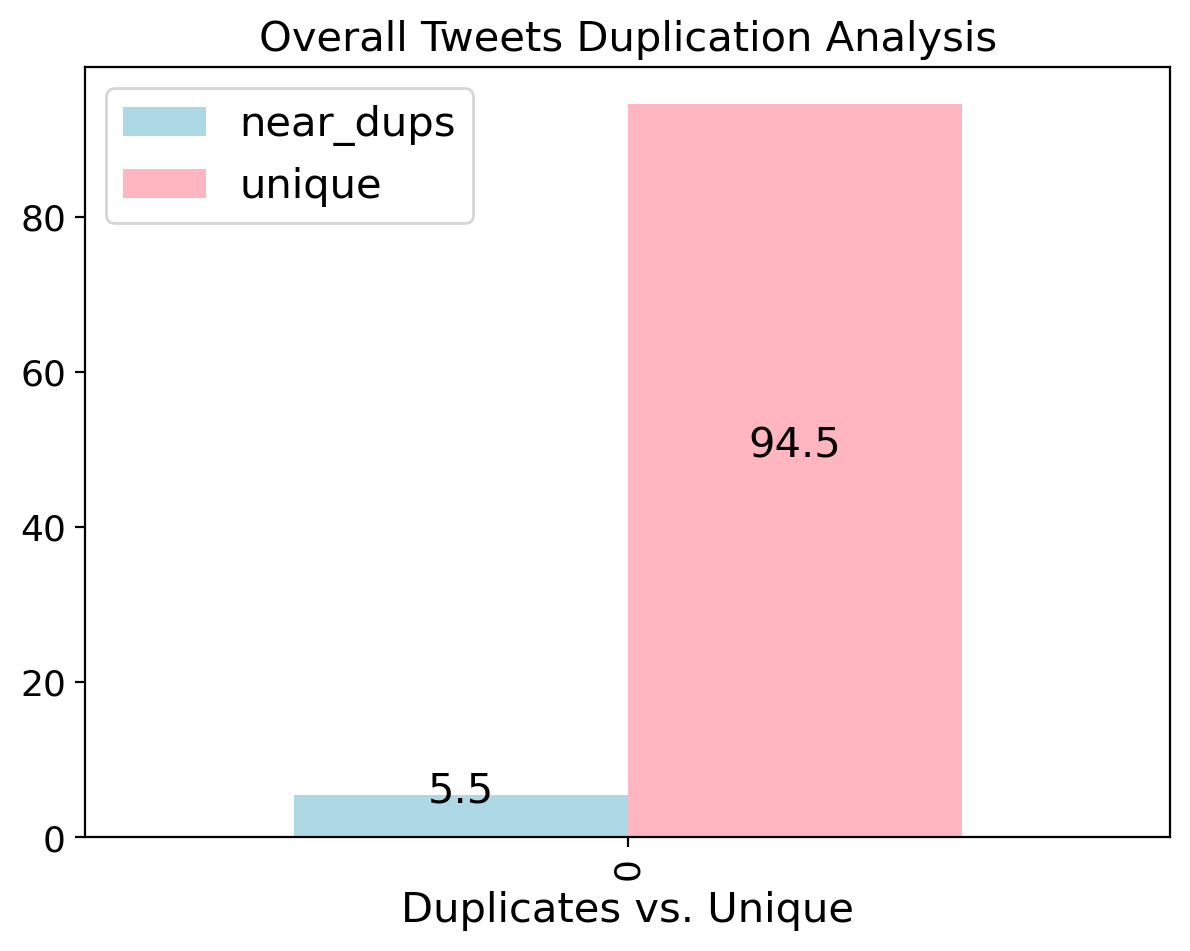

In [171]:
# text
# overall_dups_ratio = overall_dups/ngo_records*100
# overall_uniques_ratio = overall_uniques/ngo_records*100
overall_dups_df = pd.DataFrame.from_dict({'near_dups': [5.5], 'unique': [100-5.5]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=overall_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Overall Tweets Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### **Similarity Test with MinHashLSH - NGOs**

#### Select NGOs relevant data

In [12]:
ngo_raw = df.filter((df.twitterer_catogory == 'ngo') & (df.original_tweet==True) & (df.tweet_text.isNotNull()))

In [13]:
ngo_raw.limit(5)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory
1609295957996490753,0,Sat Dec 31 21:10:...,0,en,college safety bu...,113554326,lawanna bean,send postcards to...,869,10854,false,Fri Feb 12 05:43:...,null,null,null,false,null,null,null,null,null,null,null,null,true,ngo
1609296027667800066,0,Sat Dec 31 21:10:...,0,en,"in august, i star...",1366727640351207426,kitty grant,news editor @redb...,127,1010,false,Tue Mar 02 12:30:...,null,null,null,false,null,null,null,null,null,null,null,null,true,ngo
1609296253602627589,0,Sat Dec 31 21:11:...,0,en,college student a...,14213195,msn india,your daily fix of...,28974,1,false,Tue Mar 25 04:29:...,null,null,null,false,null,null,null,null,null,null,null,null,true,ngo
1609296317007941633,0,Sat Dec 31 21:11:...,0,en,☑️college footbal...,358986342,uefa nations leag...,watch uefa nation...,149,263,false,Sat Aug 20 20:53:...,null,null,null,false,wreets Watch 202...,null,null,null,null,null,null,null,true,ngo
1609298146152284160,0,Sat Dec 31 21:19:...,0,en,best tv shows i s...,21889483,josh tyler,deputy us editor ...,451,130038,false,Wed Feb 25 17:17:...,null,null,null,false,null,null,null,null,null,null,null,null,true,ngo


In [14]:
ngo_raw.count()

735914

In [15]:
# Take about 7,000 samples
ngo = ngo_raw.sample(withReplacement=False, fraction=0.01, seed=8)

#### 1. Prep and Clean-up, remove stopwords and create index

In [16]:
ngo_text = ngo.select(['tweet_text'])

In [17]:
StopWords = stopwords.words("english")

ngo_text = ngo_text.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

ngo_tokens = ngo_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.sub("@[A-Za-z0-9_]+","", document))\
    .map( lambda document: re.sub(r'http\S+',"", document))\
    .map( lambda document: re.sub(r'#\w+',"", document))\
    .map( lambda document: re.sub(r'[^\w\s]', '', document))\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 2] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

# ngo_tokens_df = ngo_tokens_text.toDF(['tokens', 'id']).filter(size("tokens")>=1)

In [18]:
row = Row('ngo_text')
ngo_text_df = ngo_text.map(row).zipWithIndex().toDF(['NGO_text','id'])
ngo_text_df.limit(5)

NGO_text,id
{tories out there...,0
{i dont recall ma...,1
{tpsc recruitment...,2
{@zoopaeth it’s n...,3
{@sassysemite @li...,4


In [19]:
ngo_text_token = spark.createDataFrame(ngo_tokens, ['list_of_words',"id"])
ngo_text_token  = ngo_text_token.where(col('list_of_words').getItem(0).isNotNull())
ngo_text_token.limit(5).toPandas()

,list_of_words,id
0,"[tories, ashamed, people, woefully, lowcalibre, representing, mean, embarrassingly, cringeinducingly, school, really, isnt, earning, astronomical, fees, days]",0
1,"[dont, recall, many, airplane, tantrum, videos, southwest, tbh, ive, always, great, experiences, flying, flew, lot, college, might, first, class, passenger, thing, lowkey]",1
2,"[tpsc, recruitment, 2022, apply, assistant, professor, kokborok, posts, salary, rs57700, 182400, last, date, 08062022, know, amp, apply, click]",2
3,"[coincidence, college, back, session, penguins, pumping]",3
4,"[youll, probably, find, thing, every, college, well, maybe, kabul, poly, tech]",4


In [20]:
ngo_text_token.count()

7389

#### 2. Fit countvectorizer to create word features

In [21]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
ngo_vectorize_text = vectorize.fit(ngo_text_token).transform(ngo_text_token)

In [22]:
ngo_vectorize_text.limit(5).toPandas()

,list_of_words,id,features
0,"[tories, ashamed, people, woefully, lowcalibre, representing, mean, embarrassingly, cringeinducingly, school, really, isnt, earning, astronomical, fees, days]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[dont, recall, many, airplane, tantrum, videos, southwest, tbh, ive, always, great, experiences, flying, flew, lot, college, might, first, class, passenger, thing, lowkey]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...)"
2,"[tpsc, recruitment, 2022, apply, assistant, professor, kokborok, posts, salary, rs57700, 182400, last, date, 08062022, know, amp, apply, click]",2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[coincidence, college, back, session, penguins, pumping]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[youll, probably, find, thing, every, college, well, maybe, kabul, poly, tech]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


#### 3. Fit MinHashLSH to create hash table

In [23]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
text_model = mh.fit(ngo_vectorize_text)
ngo_hashed = mh.fit(ngo_vectorize_text).transform(ngo_vectorize_text)

In [24]:
ngo_hashed.limit(5).toPandas()

,list_of_words,id,features,hashes
0,"[tories, ashamed, people, woefully, lowcalibre, representing, mean, embarrassingly, cringeinducingly, school, really, isnt, earning, astronomical, fees, days]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[209418533.0], [99376275.0], [67942446.0], [198722649.0], [21541099.0]]"
1,"[dont, recall, many, airplane, tantrum, videos, southwest, tbh, ive, always, great, experiences, flying, flew, lot, college, might, first, class, passenger, thing, lowkey]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...)","[[18678956.0], [17063584.0], [82277968.0], [415601093.0], [101788110.0]]"
2,"[tpsc, recruitment, 2022, apply, assistant, professor, kokborok, posts, salary, rs57700, 182400, last, date, 08062022, know, amp, apply, click]",2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[109003452.0], [276091000.0], [30854182.0], [277430784.0], [304465379.0]]"
3,"[coincidence, college, back, session, penguins, pumping]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[47945584.0], [49060945.0], [1113382060.0], [180241883.0], [138062126.0]]"
4,"[youll, probably, find, thing, every, college, well, maybe, kabul, poly, tech]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[4045642.0], [603996143.0], [45189704.0], [4080175.0], [108339905.0]]"


In [25]:
ngo_hashed_text = ngo_text_df.join(ngo_hashed, "id", how = 'left')

In [26]:
# ngo_hashed_text.limit(2)

In [27]:
ngo_hashed_text.count()

7391

#### 4.Establish similarity threshold and return near-duplicate records

In [28]:
jaccard_distance = 0.3

In [29]:
ngo_dups_text = text_model.approxSimilarityJoin(ngo_hashed_text,ngo_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.NGO_text').alias('NGO_text_A'),
            col('datasetB.NGO_text').alias('NGO_text_B'),
            )

In [30]:
# ngo_dups_text.limit(2)

In [ ]:
ngo_dups_30 = ngo_dups_text
ngo_dups_text.cache()
ngo_dups_text.limit(5).toPandas()

In [ ]:
# ngo_dups_text.count()

In [ ]:
ngo_records = ngo_hashed_text.count()

In [ ]:
ngo_dups = ngo_dups_text.select('id_A').distinct().count()

In [ ]:
ngo_uniques = ngo_records - ngo_dups

In [ ]:
# ngo_records = ngo_sample.count()
# ngo_dups = ngo_dups_text.select('id_A').distinct().count()
# ngo_uniques = ngo_records - ngo_dups

print ('Total records: ', ngo_records )
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', ngo_dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', ngo_uniques)

Total records:  7391
Duplicate titles based on { 0.3 } jaccard distance:  151
Unique titles based on { 0.3 } jaccard distance:  0.3 :  7240


#### 5. Near-duplicates V.S. Unique Visualization

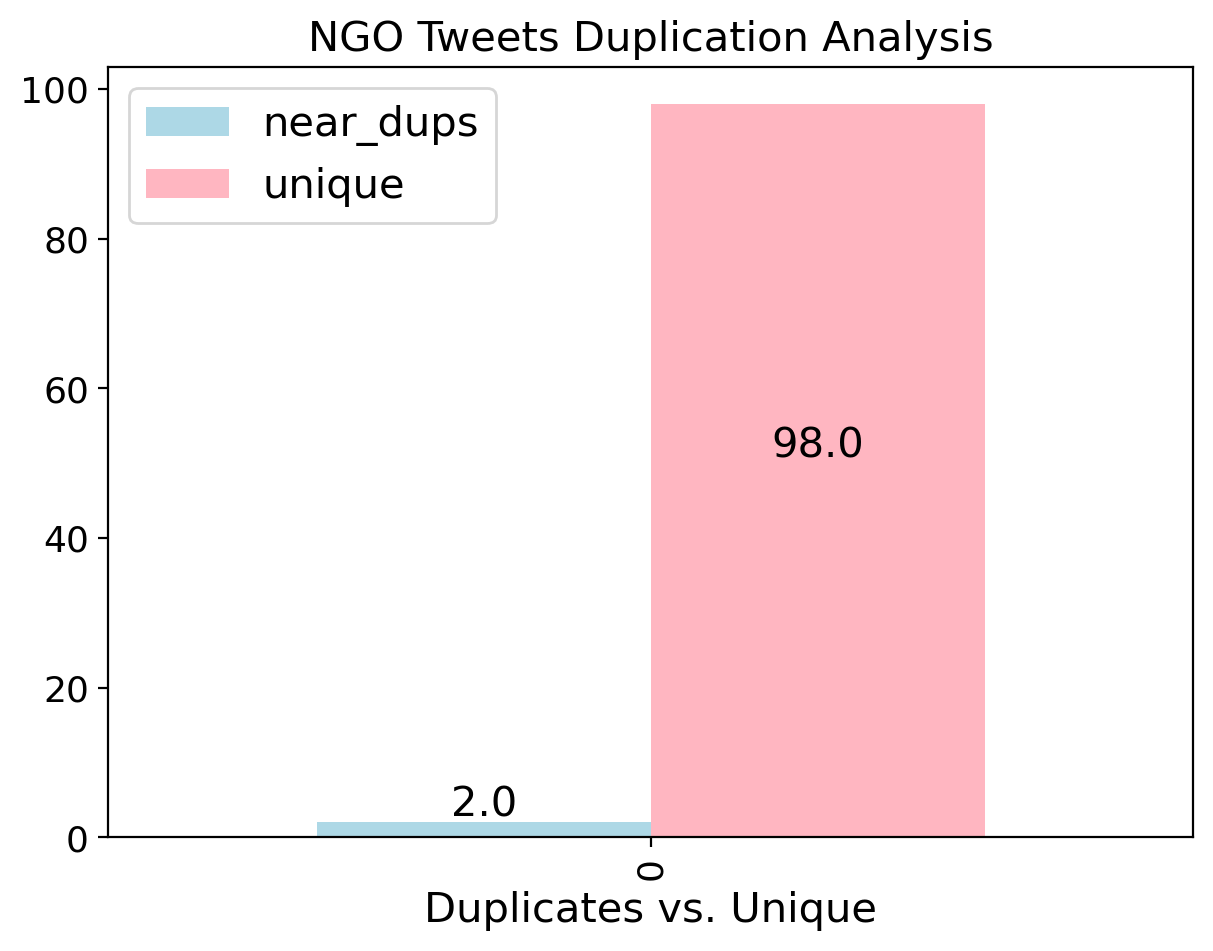

In [ ]:
# text
ngo_dups_ratio = ngo_dups/ngo_records*100
ngo_uniques_ratio = ngo_uniques/ngo_records*100
ngo_dups_df = pd.DataFrame.from_dict({'near_dups': [ngo_dups_ratio], 'unique': [ngo_uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=ngo_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('NGO Tweets Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### **Similarity Test with MinHashLSH - Government entities**

#### Select government relevant data

In [ ]:
gov = df.filter((df.twitterer_catogory == 'government_entities') & (df.original_tweet==True) & (df.tweet_text.isNotNull()))

In [ ]:
gov.limit(2)

tweet_id,tweet_likes,time_tweet_created,tweet_reply_count,language,tweet_text,user_id,user_name,user_description,user_followers_count,user_like_count,verified_user,time_account_created,location,country_name,country_code,is_retweeted,retweeted_from,rt_created_time,rt_likes,rt_count,rt_reply_count,rt_hashtags,rt_usr_id,rt_id,original_tweet,twitterer_catogory
1514974545920335878,0,Fri Apr 15 14:30:...,0,en,i just added @nex...,479980633,jacqueline collins,2021 national bus...,4319,18154,false,Wed Feb 01 00:22:...,null,null,null,false,NextGenPF Badge #...,null,null,null,null,null,null,null,true,government_entities
1514974716242501633,0,Fri Apr 15 14:31:...,0,en,"this is a ""journa...",928232964,andrew wong,us army reserve (...,102,4393,false,Mon Nov 05 19:21:...,null,null,null,false,null,null,null,null,null,null,null,null,true,government_entities


In [ ]:
gov.count()

338078

In [ ]:
# Take about 30,000 samples
gov = gov.sample(withReplacement=False, fraction=0.1, seed=8)

#### 1. Prep and Clean-up, remove stopwords and create index

In [ ]:
gov_text = gov.select(['tweet_text'])

In [ ]:
gov_text = gov_text.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

gov_tokens = gov_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.sub("@[A-Za-z0-9_]+","", document))\
    .map( lambda document: re.sub(r'http\S+',"", document))\
    .map( lambda document: re.sub(r'#\w+',"", document))\
    .map( lambda document: re.sub(r'[^\w\s]', '', document))\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [ ]:
row = Row('gov_text')
gov_text_df = gov_text.map(row).zipWithIndex().toDF(['gov_text','id'])
gov_text_df.limit(5)

gov_text,id
{when you’re sat ...,0
{dr. pavani chala...,1
{@vforvelvetta @v...,2
{@freeazfuck @wen...,3
{defunding public...,4


In [ ]:
gov_text_token = spark.createDataFrame(gov_tokens, ["list_of_words","id"])
gov_text_token  = gov_text_token.where(col('list_of_words').getItem(0).isNotNull())
gov_text_token.limit(5).toPandas()

,list_of_words,id
0,"[youre, watching, england, iran, game, receive, text, message, school, chair, governors, inspected, tomorrow]",0
1,"[pavani, chalasani, oncologist, tucson, arizona, affiliated, multiple, directorhematologyoncology, fellowship, associate, professor, medicine, professor, staff, university, arizona, cancer, center]",1
2,"[please, help, situation, father, passed, losing, pending, medical, bills, college, fees, donate, retweet, fundraiser]",2
3,"[definitely, parents, fault, many, reasons, young, children, hold, would, show, friends, school, deliberately, shoot, teacher]",3
4,"[defunding, public, schools, fully, funding, football, programs]",4


In [ ]:
gov_text_token.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [ ]:
gov_text_token.count()

33730

#### 2. Fit countvectorizer to create word features

In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
gov_vectorize = vectorize.fit(gov_text_token).transform(gov_text_token)

In [ ]:
gov_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[youre, watching, england, iran, game, receive, text, message, school, chair, governors, inspected, tomorrow]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[pavani, chalasani, oncologist, tucson, arizona, affiliated, multiple, directorhematologyoncology, fellowship, associate, professor, medicine, professor, staff, university, arizona, cancer, center]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[please, help, situation, father, passed, losing, pending, medical, bills, college, fees, donate, retweet, fundraiser]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[definitely, parents, fault, many, reasons, young, children, hold, would, show, friends, school, deliberately, shoot, teacher]",3,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...)"
4,"[defunding, public, schools, fully, funding, football, programs]",4,"(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


#### 3. Fit MinHashLSH to create hash table

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(gov_vectorize)
gov_hashed = mh.fit(gov_vectorize).transform(gov_vectorize)

In [ ]:
gov_hashed_text = gov_text_df.join(gov_hashed, "id", how = 'left')

In [ ]:
gov_hashed_text.limit(5)

id,gov_text,list_of_words,features,hashes
26,"{in feb 2022, 74%...","[2022, public, sc...","(41641,[2,3,6,137...","[[5.02084813E8], ..."
29,{nearly 1/2 of re...,"[nearly, repub, p...","(41641,[0,13,117,...","[[3.5836882E7], [..."
474,{how about you pr...,"[propose, taxing,...","(41641,[0,7,14,61...","[[2.9276036E7], [..."
65,{my baby and her ...,"[baby, schoolmate...","(41641,[2,12,30,5...","[[4.98562937E8], ..."
191,{teagasc is hosti...,"[teagasc, hosting...","(41641,[0,72,191,...","[[4.7945584E7], [..."


In [ ]:
# gov_sample = gov_hashed_text.sample(withReplacement=False, fraction=0.01, seed=8)

In [ ]:
# gov_hashed.limit(3)

In [ ]:
gov_hashed_text.count()

33736

#### 4. Establish similarity threshold and return near-duplicate records

In [ ]:
jaccard_distance = 0.3

gov_dups_text = model.approxSimilarityJoin(gov_hashed_text, gov_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.gov_text').alias('gov_text_A'),
            col('datasetB.gov_text').alias('gov_text_B'),
            )

In [ ]:
gov_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,gov_text_A,gov_text_B
0,0.000000,26081,31978,"(@radlup to a private school,)","(@yvonneburdett3 @amrinedouglas private school tho,)"
1,0.238095,14730,16839,"(@judiciarygop @joebiden the real joke here: that a former college coach \n@jim_jordan at ohio state university who let a sexual predator (team doctor) prey on 170+ young men from the wrestling team for years and failed to report it!!!!,)","(@gopoversight @repjamescomer discuss this today please: that a former college coach @jim_jordan at ohio state university who let a sexual predator (team doctor) prey on 170+ young men from the wrestling team for years and failed to report it!!!!,)"
2,0.000000,9098,28536,"(@eacamp3 hypocrite maga republicans profess passionate desire to teach christianity in public schools, yet their so-called ""christian behavior"" towards non-maga americans is the exact opposite of jesus' teachings! so called ""evangelical christians"" behave more like ""evangelical fascists""! https://t.co/xizhgnsffg,)","(@joncoopertweets hypocrite maga republicans profess passionate desire to teach christianity in public schools, yet their so-called ""christian behavior"" towards non-maga americans is the exact opposite of jesus' teachings! so called ""evangelical christians"" behave more like ""evangelical fascists""! https://t.co/dvpjyqe4nv,)"
3,0.000000,229,1135,"(@drsharma_ny please help my family\nwe are in bad situation after my father passed away\nfrom losing my dad to pending medical bills &amp; college fees, we are devastated.\n\nplz donate &amp; retweet if possible\n\nverified fundraiser &amp; details-:\nhttps://t.co/kplut5azpj,)","(@mohansinha please help my family\nwe are in bad situation after my father passed away\nfrom losing my dad to pending medical bills &amp; college fees, we are devastated.\n\nplz donate &amp; retweet if possible\n\nverified fundraiser &amp; details👇🏻\nhttps://t.co/kplut5jwnj,)"
4,0.000000,1265,9399,"(@purviparwani please help my family\nwe are in bad situation after my father passed away\nfrom losing my dad to pending medical bills &amp; college fees, we are devastated.\n\nplz donate &amp; retweet if possible\n\nverified fundraiser &amp; details👇🏻\nhttps://t.co/kplut5azpj,)","(@upword_ please help my family\nwe are in bad situation after my father passed away\nfrom losing my dad to pending medical bills &amp; college fees, we are devastated.\n\nplz donate &amp; retweet if possible\n\nverified fundraiser &amp; details👇🏻\nhttps://t.co/kplut5azpj,)"


In [ ]:
# gov_dups_text.count()

In [ ]:
gov_dups_30 = gov_dups_text
gov_dups_text.cache()
gov_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,gov_text_A,gov_text_B
0,0.000000,29175,31113,"(@damiadenuga .@realchiefpriest good afternoon sir, please, my younger brother just got admission into the university and i've been trying to fund his tuition fee and accomodation but it has not been easy.\neverything cost about 97k, please sir help us out. nothing is too small. god bless sir.,)","(@realchiefpriest good afternoon sir, please, my younger brother just got admission into the university and i've been trying to fund his tuition fee and accomodation but it has not been easy.\neverything cost about 97k, please sir help us out. nothing is too small. god bless sir.,)"
1,0.000000,26081,31978,"(@radlup to a private school,)","(@yvonneburdett3 @amrinedouglas private school tho,)"
2,0.238095,14730,16839,"(@judiciarygop @joebiden the real joke here: that a former college coach \n@jim_jordan at ohio state university who let a sexual predator (team doctor) prey on 170+ young men from the wrestling team for years and failed to report it!!!!,)","(@gopoversight @repjamescomer discuss this today please: that a former college coach @jim_jordan at ohio state university who let a sexual predator (team doctor) prey on 170+ young men from the wrestling team for years and failed to report it!!!!,)"
3,0.000000,17337,24022,"(@jdvance1 @donaldjtrumpjr clown college?,)","(this college is a clown for doing this,)"
4,0.000000,7642,8558,"(@shazdumpp hello, interested ✨ 3rd-year college here. you may dm me 💗\nhttps://t.co/vxgvouvwln,)","(@aishclient hello, interested ✨ 3rd-year college here. you may dm me 💗\nhttps://t.co/vxgvouvwln,)"


#### 5. Near-duplicates V.S. Unique Visualization

In [ ]:
gov_records = gov_hashed_text.count()

In [ ]:
gov_dups = gov_dups_text.select('id_A').distinct().count()

In [ ]:
gov_uniques = gov_records - gov_dups

In [ ]:
print ('Total records: ', gov_records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', gov_dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', gov_uniques)

Total records:  33736
Duplicate titles based on { 0.3 } jaccard distance:  1074
Unique titles based on { 0.3 } jaccard distance:  0.3 :  32662


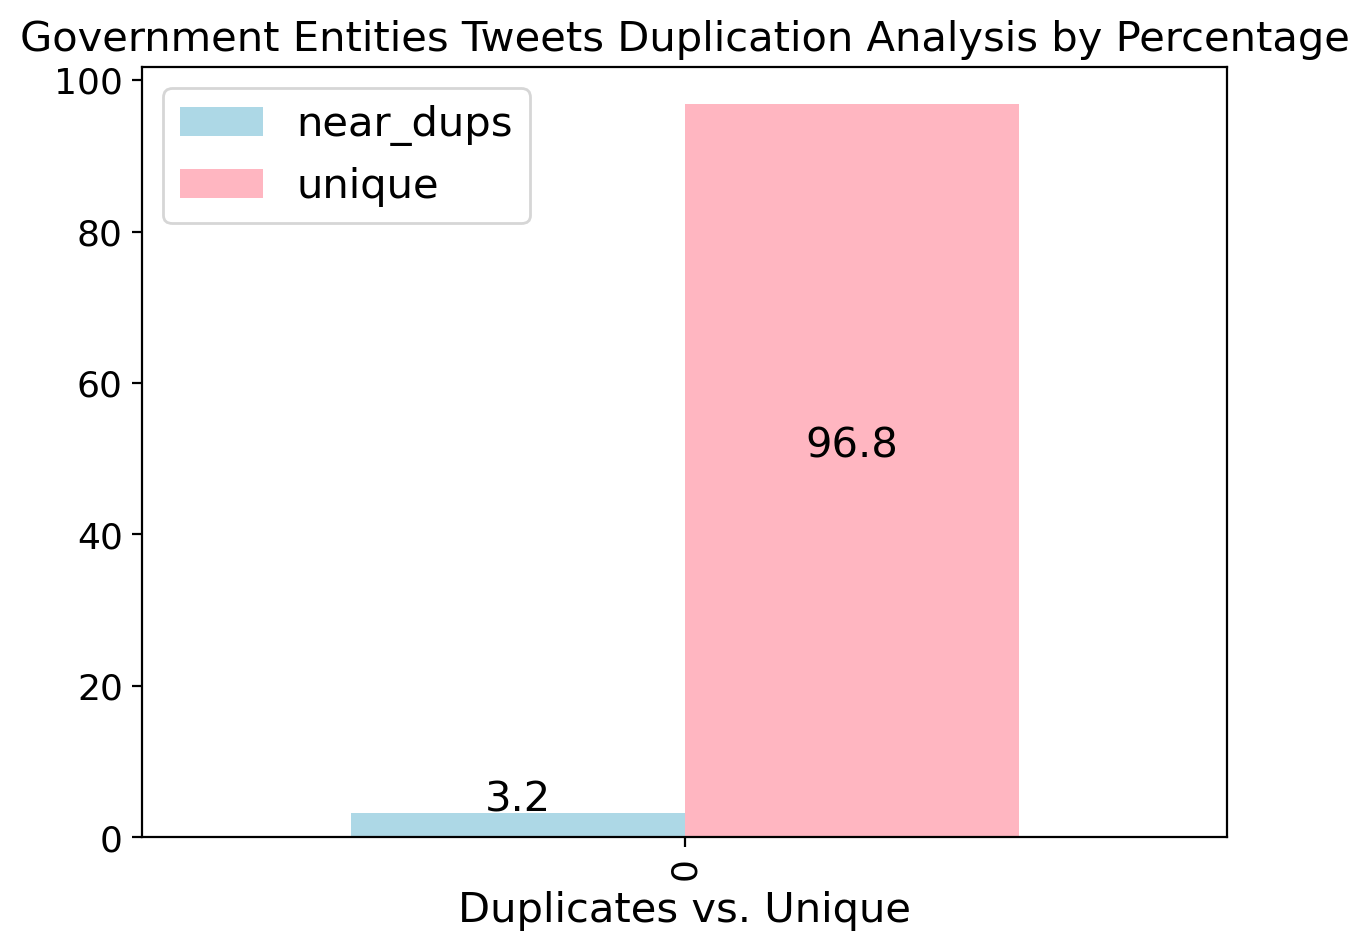

In [ ]:
dups_ratio = gov_dups/gov_records*100
uniques_ratio = gov_uniques/gov_records*100
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_ratio], 'unique': [uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Government Entities Tweets Duplication Analysis by Percentage', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### **Similarity Test with MinHashLSH - Universities**

#### Select Universities relevant data

In [ ]:
uni = df.filter((df.twitterer_catogory == 'universities') & (df.original_tweet==True) & (df.tweet_text.isNotNull()))

In [ ]:
uni.count()

432216

In [ ]:
uni = uni.sample(withReplacement=False, fraction=0.1, seed=8)

In [ ]:
uni_text = uni.select(['tweet_text'])

#### 1. Prep and Clean-up, remove stopwords and create index

In [ ]:
uni_text = uni_text.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

uni_tokens = uni_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.sub("@[A-Za-z0-9_]+","", document))\
    .map( lambda document: re.sub(r'http\S+',"", document))\
    .map( lambda document: re.sub(r'#\w+',"", document))\
    .map( lambda document: re.sub(r'[^\w\s]', '', document))\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [ ]:
row = Row('uni_text')
uni_text_df = uni_text.map(row).zipWithIndex().toDF(['uni_text','id'])
uni_text_df.limit(5)

uni_text,id
{@cbcfifth do all...,1321
{@cajunmsteacher ...,1322
{@anthonyesolen y...,1323
{target has been ...,1324
{@nathaliejacoby1...,1325


In [ ]:
uni_text_token = spark.createDataFrame(uni_tokens, ["list_of_words","id"])
uni_text_token = uni_text_token.where(col('list_of_words').getItem(0).isNotNull())
uni_text_token.limit(5).toPandas()

,list_of_words,id
0,"[great, timing, teaching, electoral, college, today, tomorrow]",0
1,"[rights, respecting, steering, received, entries, whole, school, steering, group, people, class, selected, announced, next, rights, respecting, demonstrated, interest]",1
2,"[schools, deserve]",2
3,"[rhp1b, benjamin, raschke, kansas, city, christian, 2023, commits, central, methodist]",3
4,"[college, coaches, heres, playmaker, loves, ball, hands]",4


In [ ]:
uni_text_token.count()

43066

#### 2. Fit countvectorizer to create word features

In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
uni_vectorize_text = vectorize.fit(uni_text_token).transform(uni_text_token)

In [ ]:
uni_vectorize_text.limit(5).toPandas()

,list_of_words,id,features
0,"[great, timing, teaching, electoral, college, today, tomorrow]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[rights, respecting, steering, received, entries, whole, school, steering, group, people, class, selected, announced, next, rights, respecting, demonstrated, interest]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[schools, deserve]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rhp1b, benjamin, raschke, kansas, city, christian, 2023, commits, central, methodist]",3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[college, coaches, heres, playmaker, loves, ball, hands]",4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


#### 3. Fit MinHashLSH to create hash table

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(uni_vectorize_text)
uni_hashed = mh.fit(uni_vectorize_text).transform(uni_vectorize_text)

In [ ]:
uni_hashed.limit(3)

list_of_words,id,features,hashes
"[great, timing, t...",0,"(40755,[1,16,21,3...","[[1.9024249E8], [..."
"[rights, respecti...",1,"(40755,[0,28,64,7...","[[4.7945584E7], [..."
"[schools, deserve]",2,"(40755,[6,513],[1...","[[1.629862981E9],..."


In [ ]:
uni_hashed.count()

43066

In [ ]:
uni_hashed_text = uni_text_df.join(uni_hashed, "id", how = 'left').cache()
uni_hashed_text.limit(5)

id,uni_text,list_of_words,features,hashes
26,{sign up for our ...,"[sign, first, ann...","(40755,[1,17,22,1...","[[2.48822924E8], ..."
29,{westminster scho...,"[westminster, sch...","(40755,[0,3,6,9,1...","[[4.7945584E7], [..."
474,{@thejunkyarddiva...,"[grade, bilingual...","(40755,[0,8,12,13...","[[4.7945584E7], [..."
964,{@smi52191 @kkirt...,"[take, look, cons...","(40755,[28,85,90,...","[[3.1800648E7], [..."
1677,{middle school pa...,"[middle, school, ...","(40755,[0,2,14,42...","[[4.7945584E7], [..."


#### 4.Establish similarity threshold and return near-duplicate records

In [ ]:
jaccard_distance = 0.3

uni_dups_text = model.approxSimilarityJoin(uni_hashed_text, uni_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.uni_text').alias('uni_text_A'),
            col('datasetB.uni_text').alias('uni_text_B'),
            )

In [ ]:
uni_dups_30 = uni_dups_text
uni_dups_text.cache()
uni_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,uni_text_A,uni_text_B
0,0.10,1873,13094,"(@cgeutexas @spartan_math @hayesholly2 @kkirtley26 @starvi_ng ☀️good morning☀️\n\ni’m a 2nd grade teacher 👩‍🏫 from a title 1 school in michigan &amp; would love ❤️ some help to #clearthelist #b2swithalane #johnclearmylist #cojoclearthelist \n✏️ pencils\n✂️glue sticks\n🔬stem morning bin supplies\n🍿snacks\n📖 books\n\nhttps://t.co/iwydtmgoa7 https://t.co/vewtkwcaog,)","(@reneknottsports 👋🏻 hello!\n\ni’m a 2nd grade teacher 👩‍🏫 from a title 1 school in michigan &amp; would love ❤️ some help to #clearthelist #magentamagic #johnclearmylist #cojoclearthelist \n✏️ pencils\n✂️glue sticks\n🔬stem morning bin supplies\n🍿snacks\n📖 books\n\nhttps://t.co/iwydtmgoa7 https://t.co/s6qxsveuze,)"
1,0.00,7047,27070,"(@pam_vietz 🍎hi! i'm a 5th grade #math #teacher at a full inclusion title 1 school near #pittsburgh pa. my students would love a whiteboard table to do math and science projects. please rt and help me #clearthelist✏️\n\nhttps://t.co/kxhtej3ntz\n\n#teachertwitter #johnclearmylist #magentamagic,)","(@mshickam @beckykurkowski 🍎hi! i'm a 5th grade #math #teacher at a full inclusion title 1 school near #pittsburgh pa. my students would love a whiteboard table to do math and science projects. please rt and help me #clearthelist✏️\n\nhttps://t.co/kxhtej3ntz\n\n#teachertwitter #johnclearmylist #magentamagic,)"
2,0.25,18208,30824,"(@imbatman2018 @donorschoose @notbatmanyet @kkirtley26 22 yrs of california teaching☀️1st-3rd grade special day class🌻looking forward to the best #school year ever✏️my @amazon wishlist.https://t.co/u8kdh8ttqx #kids #students #community #teachers #bettertogether #clearthelist2022 #specialeducation #kindnessmatters #thankyou 🖍 https://t.co/k5wp843sr5,)","(@lhblovesedu @dbrenee 👋🏾22 yrs of california teaching☀️1st-3rd grade special day class🌻back at it tomorrow🍎looking forward to the best #school year ever✏️my @amazon wishlist.https://t.co/u8kdh8ttqx #kids #community #teachers #bettertogether #clearthelist2022 #specialeducation #kindnessmatters 🖍 https://t.co/psm8v4sfwh,)"
3,0.00,11498,19762,"(@twinstantfamily thank you for your support. i am a kindergarten teacher in a title 1 school in pennsylvania. any help is greatly appreciated. inspiring little minds is amazing and i am excited for a new school year!\n#clearthelist #clearthelist2022\n#adoptateacher\nhttps://t.co/9gfugevddn https://t.co/womaqpcmr0,)","(@steelcityhelps @amazon @donorschoose thank you for your support. i am a kindergarten teacher in a title 1 school in pennsylvania. any help is greatly appreciated. inspiring little minds is amazing and i am excited for a new school year!\n#clearthelist #clearthelist2022\n#adoptateacher\nhttps://t.co/9gfugevddn,)"
4,0.00,1132,35689,"(@msstubbs3 hello &amp; thank you! i’m a high school superhero loving special education teacher from mi. could you rt my @donorschoose project? i’m looking to bring more supplies into the classroom for hands on learning. https://t.co/nnvi3qvm1y https://t.co/a9cmk6fpo3,)","(@nicolehaw1 hello &amp; thank you! i’m a high school superhero loving special education teacher from mi. could you rt my @donorschoose project? i’m looking to bring more supplies into the classroom for hands on learning. https://t.co/nnvi3qvm1y https://t.co/tubos5tryb,)"


#### 5. Near-duplicates V.S. Unique Visualization

In [ ]:
uni_records = uni_hashed_text.count()

In [ ]:
uni_dups = uni_dups_text.select('id_A').distinct().count()

In [ ]:
uni_uniques = uni_records - uni_dups

In [ ]:
print ('Total records: ', uni_records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', uni_dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uni_uniques)

Total records:  43086
Duplicate titles based on { 0.3 } jaccard distance:  4939
Unique titles based on { 0.3 } jaccard distance:  0.3 :  38147


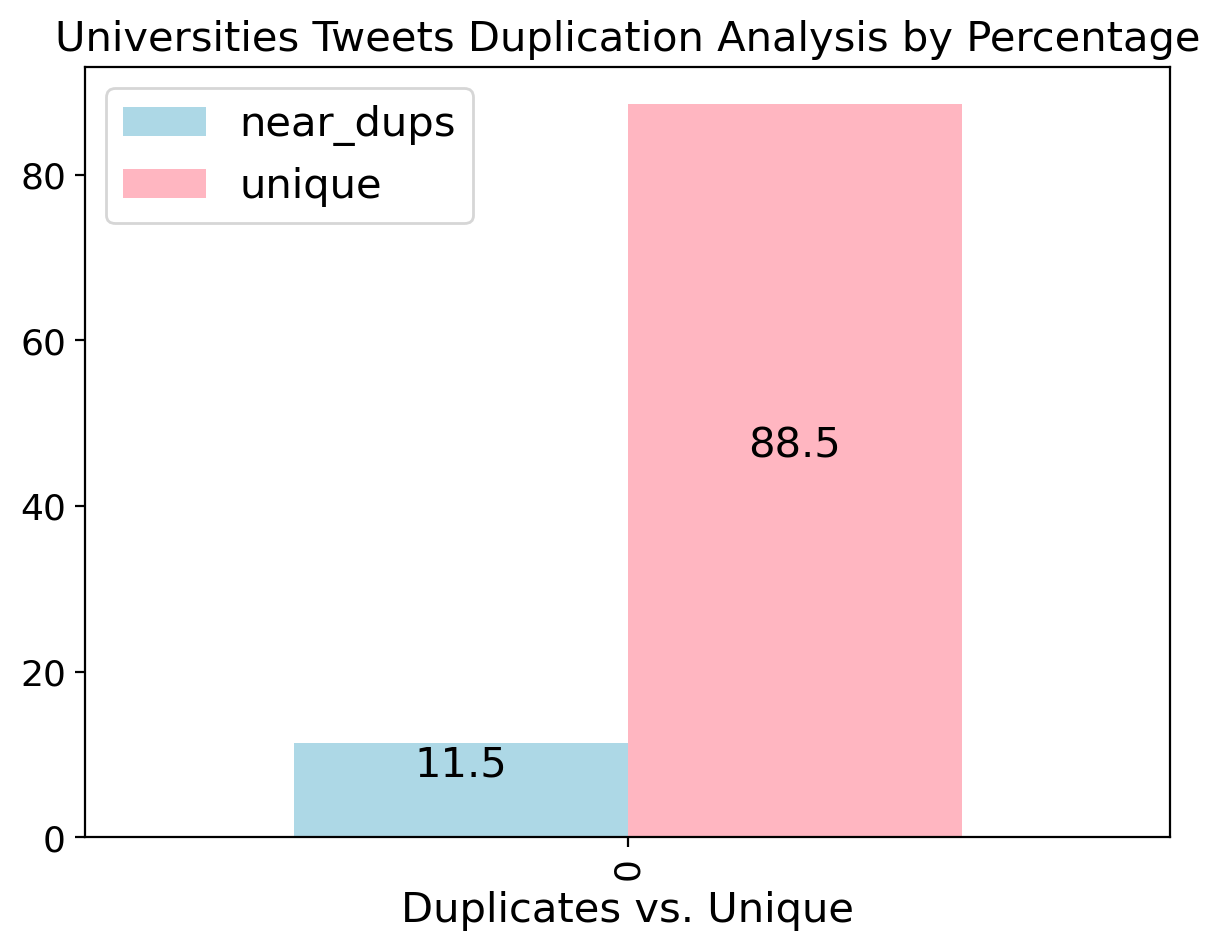

In [ ]:
dups_ratio = uni_dups/uni_records*100
uniques_ratio = uni_uniques/uni_records*100
dups_df = pd.DataFrame.from_dict({'near_dups': [dups_ratio], 'unique': [uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Universities Tweets Duplication Analysis by Percentage', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### **Similarity Test with MinHashLSH - Schools**

#### Select Schools relevant data

In [142]:
sch = df.filter((df.twitterer_catogory == 'schools') & (df.original_tweet==True) & (df.tweet_text.isNotNull()))

In [143]:
sch.count()

708012

In [144]:
sch = sch.sample(withReplacement=False, fraction=0.01, seed=8)

In [145]:
sch.count()

7131

#### 1. Prep and Clean-up, remove stopwords and create index

In [146]:
sch_text = sch.select(['tweet_text'])

In [147]:
StopWords = stopwords.words("english")

sch_text = sch_text.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

sch_tokens = sch_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.sub("@[A-Za-z0-9_]+","", document))\
    .map( lambda document: re.sub(r'http\S+',"", document))\
    .map( lambda document: re.sub(r'#\w+',"", document))\
    .map( lambda document: re.sub(r'[^\w\s]', '', document))\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 2] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()


In [148]:
row = Row('sch_text')
sch_text_df = sch_text.map(row).zipWithIndex().toDF(['sch_text','id'])
sch_text_df.limit(5)

sch_text,id
{@troytrojansfb @...,556
{@t_gibbs10 we 👀...,557
{@gregjaffe david...,558
{time management ...,559
{everyone can gra...,560


In [149]:
sch_text_token = spark.createDataFrame(sch_tokens, ['list_of_words',"id"])
sch_text_token  = sch_text_token.where(col('list_of_words').getItem(0).isNotNull())
sch_text_token.limit(5).toPandas()

,list_of_words,id
0,"[school, governors, needed, looking, recruit, number, governors, local, advisory, website, find, schools, info, apply, email, governance, team, infoacademy]",0
1,"[dku, professors, peng, sun, luyao, zhang, zhenghui, huo, received, grants, chinas, nsfc, fund, research, ranging, theoretical, mathematics, transportation, systems]",1
2,"[asked, gather, ideas, creation, stateoftheart, experience, using, latest, emerging]",2
3,"[indoor, 121, liverpool, college, joe, collins, assisted, jacob, position, specific, work, key, focus, lowhigh, highlow, movements, well, done, boys]",3
4,"[college, teams, mlbers, florida, gators, pete, alonsoshaun, andersonharrison, baderdane, dunningtaylor, gushueeric, hanholdrichie, martinbobby, poyneraj, pukjustin, shaferkirby, sneaddanny, young]",4


In [150]:
sch_text_token.count()

7129

#### 2. Fit countvectorizer to create word features

In [151]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
sch_vectorize_text = vectorize.fit(sch_text_token).transform(sch_text_token)

In [152]:
sch_vectorize_text.limit(5).toPandas()

,list_of_words,id,features
0,"[school, governors, needed, looking, recruit, number, governors, local, advisory, website, find, schools, info, apply, email, governance, team, infoacademy]",0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[dku, professors, peng, sun, luyao, zhang, zhenghui, huo, received, grants, chinas, nsfc, fund, research, ranging, theoretical, mathematics, transportation, systems]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[asked, gather, ideas, creation, stateoftheart, experience, using, latest, emerging]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[indoor, 121, liverpool, college, joe, collins, assisted, jacob, position, specific, work, key, focus, lowhigh, highlow, movements, well, done, boys]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[college, teams, mlbers, florida, gators, pete, alonsoshaun, andersonharrison, baderdane, dunningtaylor, gushueeric, hanholdrichie, martinbobby, poyneraj, pukjustin, shaferkirby, sneaddanny, young]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


#### 3. Fit MinHashLSH to create hash table

In [153]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(sch_vectorize_text)
sch_hashed = mh.fit(sch_vectorize_text).transform(sch_vectorize_text)

In [154]:
sch_hashed.limit(5).toPandas()

,list_of_words,id,features,hashes
0,"[school, governors, needed, looking, recruit, number, governors, local, advisory, website, find, schools, info, apply, email, governance, team, infoacademy]",0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[7583244.0], [116225142.0], [30854182.0], [351422858.0], [38840416.0]]"
1,"[dku, professors, peng, sun, luyao, zhang, zhenghui, huo, received, grants, chinas, nsfc, fund, research, ranging, theoretical, mathematics, transportation, systems]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[81770667.0], [58729788.0], [42626059.0], [41816509.0], [115105888.0]]"
2,"[asked, gather, ideas, creation, stateoftheart, experience, using, latest, emerging]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[295200300.0], [148290822.0], [556072907.0], [127710977.0], [273634096.0]]"
3,"[indoor, 121, liverpool, college, joe, collins, assisted, jacob, position, specific, work, key, focus, lowhigh, highlow, movements, well, done, boys]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[47945584.0], [269223723.0], [170790018.0], [388021887.0], [42053236.0]]"
4,"[college, teams, mlbers, florida, gators, pete, alonsoshaun, andersonharrison, baderdane, dunningtaylor, gushueeric, hanholdrichie, martinbobby, poyneraj, pukjustin, shaferkirby, sneaddanny, young]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[30304752.0], [30879614.0], [67417486.0], [27629898.0], [75795118.0]]"


In [155]:
sch_hashed_text = sch_text_df.join(sch_hashed, "id", how = 'left')

In [156]:
sch_hashed_text.limit(5)

id,sch_text,list_of_words,features,hashes
191,"{and, @ndfootball...","[played, half, te...","(18894,[0,8,94,11...","[[3.9873116E7], [..."
112,{college delibera...,"[college, deliber...","(18894,[0,25,3051...","[[4.7945584E7], [..."
113,{@sunlorrie nazi ...,"[nazi, soviet, ps...","(18894,[0,297,917...","[[4.7945584E7], [..."
155,{final 20th anniv...,"[final, 20th, ann...","(18894,[3,60,80,8...","[[5.4007798E7], [..."
167,{join the delta c...,"[join, delta, col...","(18894,[0,24,36,5...","[[4.7945584E7], [..."


#### 4. Establish similarity threshold and return near-duplicate records

In [157]:
jaccard_distance = 0.3
sch_dups_text = model.approxSimilarityJoin(sch_hashed_text,sch_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.sch_text').alias('sch_text_A'),
            col('datasetB.sch_text').alias('sch_text_B'),
            )

In [158]:
sch_dups_30 = sch_dups_text
# sch_dups_text.cache()
# sch_dups_text.limit(5).toPandas()

In [162]:
sch_records = sch_hashed_text.count()
sch_dups = sch_dups_text.select('id_A').distinct().count()
sch_uniques = sch_records - sch_dups

#### 5. Near-duplicates V.S. Unique Visualization

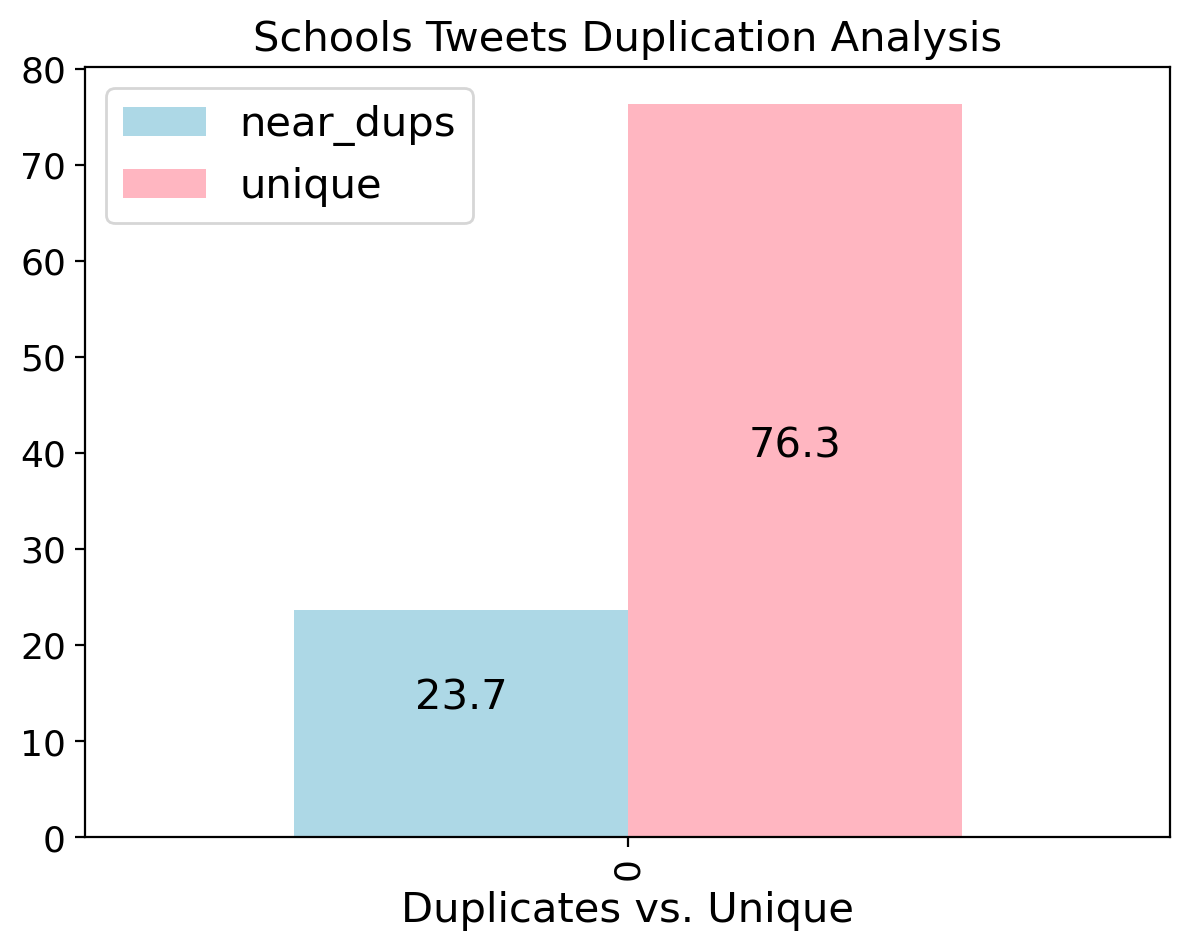

In [166]:
# text
# sch_dups_ratio = sch_dups/sch_records*100
# sch_uniques_ratio = sch_uniques/sch_records*100
# sch_dups_df = pd.DataFrame.from_dict({'near_dups': [sch_dups_ratio], 'unique': [sch_uniques_ratio]}).round(2)

sch_dups_df = pd.DataFrame.from_dict({'near_dups': [23.7], 'unique': [100-23.7]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=sch_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Schools Tweets Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
# text
# sch_dups_ratio = sch_dups/sch_records*100
# sch_uniques_ratio = sch_uniques/sch_records*100
# sch_dups_df = pd.DataFrame.from_dict({'near_dups': [sch_dups_ratio], 'unique': [sch_uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=sch_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Schools Tweets Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### **Similarity Test with MinHashLSH - News & Media**

#### Select News & Media relevant data

In [104]:
news = df.filter((df.twitterer_catogory == 'news_media') & (df.original_tweet==True) & (df.tweet_text.isNotNull()))

In [105]:
news.count()

87825

In [106]:
news = news.sample(False, 0.1, seed=0)

In [107]:
news = news.select(['tweet_text'])

#### 1. Prep and Clean-up, remove stopwords and create index

In [108]:
news_text = news.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

news_tokens = news_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.sub("@[A-Za-z0-9_]+","", document))\
    .map( lambda document: re.sub(r'http\S+',"", document))\
    .map( lambda document: re.sub(r'#\w+',"", document))\
    .map( lambda document: re.sub(r'[^\w\s]', '', document))\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [ ]:
row = Row('news_text')
news_text_df = news_text.map(row).zipWithIndex().toDF(['news_text','id'])
news_text_df.limit(5)

In [ ]:
news_text_token = spark.createDataFrame(news_tokens, ["list_of_words","id"])
news_text_token  = news_text_token.where(col('list_of_words').getItem(0).isNotNull())
news_text_token.limit(5).toPandas()

In [ ]:
news_text_token.count()

#### 2. Fit countvectorizer to create word features

In [ ]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
news_vectorize = vectorize.fit(news_text_token).transform(news_text_token)

In [ ]:
news_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[home, states, charter, schools, bridge, bipartisanship, everyone, deserves, highquality, public, schools, responsive, communities, serve]",0,"(0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[abilities, first, pleased, announce, first, session, unplanned, journey, wednesday, october, grand, success, unplanned, journey, virtual, education, series, designed, help, parents, caregivers, navigate, preschoolaged, child, disabilities]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[sure, understand, dictating, schedules, since, sports, accept, schedules, geared, towards, viewing, audience, sports, college, sports]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[bring, inquirybased, science, experiences, right, school, curiosity, wheels, ideal, science, across, grades, school, lively, afterschool, event, students, families]",3,"(0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[calypso, chimes]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


#### 3. Fit MinHashLSH to create hash table

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(news_vectorize)
news_hashed = mh.fit(news_vectorize).transform(news_vectorize)

In [ ]:
news_hashed.limit(5).toPandas()

,list_of_words,id,features,hashes
0,"[home, states, charter, schools, bridge, bipartisanship, everyone, deserves, highquality, public, schools, responsive, communities, serve]",0,"(0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[300771745.0], [380012082.0], [19017578.0], [30874972.0], [317871190.0]]"
1,"[abilities, first, pleased, announce, first, session, unplanned, journey, wednesday, october, grand, success, unplanned, journey, virtual, education, series, designed, help, parents, caregivers, navigate, preschoolaged, child, disabilities]",1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[39374484.0], [527464.0], [33353100.0], [58454178.0], [25824859.0]]"
2,"[sure, understand, dictating, schedules, since, sports, accept, schedules, geared, towards, viewing, audience, sports, college, sports]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[47945584.0], [24787626.0], [81357502.0], [168427713.0], [101788110.0]]"
3,"[bring, inquirybased, science, experiences, right, school, curiosity, wheels, ideal, science, across, grades, school, lively, afterschool, event, students, families]",3,"(0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[44922340.0], [252837398.0], [37890703.0], [293372268.0], [32074433.0]]"
4,"[calypso, chimes]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[477890998.0], [893919727.0], [1424358967.0], [402375339.0], [254923496.0]]"


In [ ]:
news_hashed_text = news_text_df.join(news_hashed, "id", how = 'left').cache()
news_hashed_text.limit(5)

id,news_text,list_of_words,features,hashes
26,{my professor try...,"[professor, tryna...","(21111,[4,60,1290...","[[6.42371465E8], ..."
29,{@g_makuachukwu2 ...,"[cant, complain, ...","(21111,[1,37,67,1...","[[1.00930984E8], ..."
474,{@thelastpinkcar ...,"[cant, argue, ins...","(21111,[0,75,107,...","[[4.7945584E7], [..."
964,{@prisus it's the...,"[preschool, daugh...","(21111,[1,11,44,5...","[[1.15057803E8], ..."
1677,{this week i host...,"[week, hosted, vi...","(21111,[3,18,44,1...","[[2.44739512E8], ..."


In [ ]:
news_hashed_text.count()

8713

#### 4. Establish similarity threshold and return near-duplicate records

In [ ]:
jaccard_distance = 0.3
news_dups_text = model.approxSimilarityJoin(news_hashed_text, news_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.news_text').alias('news_text_A'),
            col('datasetB.news_text').alias('news_text_B'),
            )

In [ ]:
news_dups_30 = news_dups_text
news_dups_text.cache()
news_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,news_text_A,news_text_B
0,0.0,5160,6738,"(psychotherapy for youth. is your teen turning to drugs or alcohol? skipping school? hanging out with the wrong crowd? or falling prey to internet dangers during the covid-19 crisis? get professional counselling from a licensed therapist.\n\nwe can help! online! on your schedule... https://t.co/jafv1w2rcq,)","(psychotherapy for youth. is your teen turning to drugs or alcohol? skipping school? hanging out with the wrong crowd? or falling prey to internet dangers during the covid-19 crisis? get professional counselling from a licensed therapist.\n\nwe can help! online! on your schedule... https://t.co/j6lsjaca8c,)"
1,0.0,2688,8060,"(@spoonofzeke @goldblooded79 college,)","(college,)"
2,0.0,2295,4830,"(@miena0599e9 dm me with your payment info to get spoiled rn 💯..i’m helping broke college students willing to spoil and paid off ur bills/needs,if you're interested just hmu ❤️❤️🤍🤍💰💰💰💰💵💵💵💵💵,)","(@charlesalmodov1 @dream dm me with your payment info to get spoiled rn 💯..i’m helping broke college students willing to spoil and paid off ur bills/needs,if you're interested just hmu ❤️❤️🤍🤍💰💰💰💰💵💵💵💵💵,)"
3,0.0,404,8060,"(@meerzuh it's college, bro.,)","(college,)"
4,0.0,1841,7392,"(what college does to a mf https://t.co/yajeeupstr,)","(@rupeshtwt not in my college.,)"


In [121]:
news_records = news_hashed_text.count()
news_dups = news_dups_text.select('id_A').distinct().count()
news_uniques = news_records - news_dups

#### 5. Near-duplicates V.S. Unique Visualization

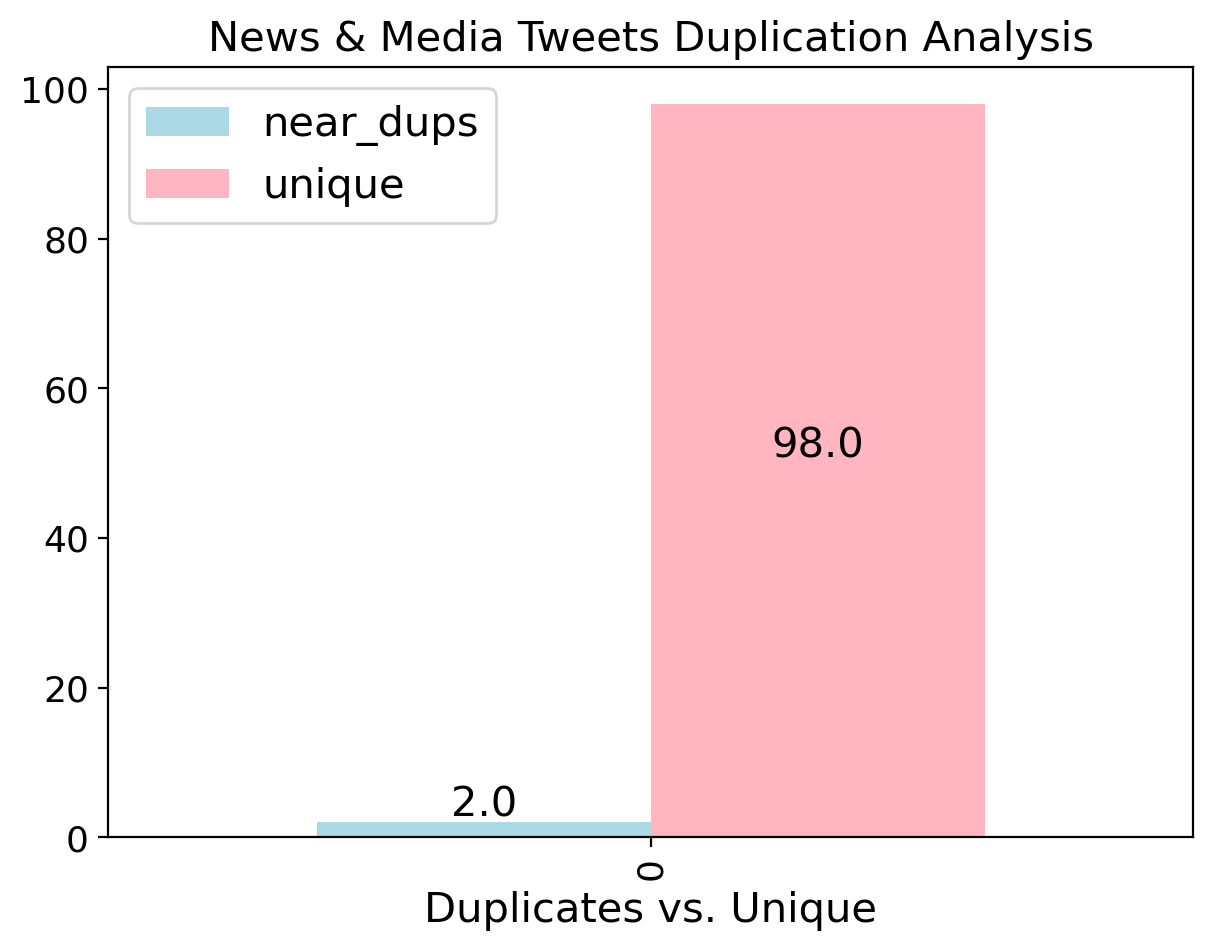

In [122]:
# text
ngo_dups_ratio = ngo_dups/ngo_records*100
ngo_uniques_ratio = ngo_uniques/ngo_records*100
ngo_dups_df = pd.DataFrame.from_dict({'near_dups': [ngo_dups_ratio], 'unique': [ngo_uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=ngo_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News & Media Tweets Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

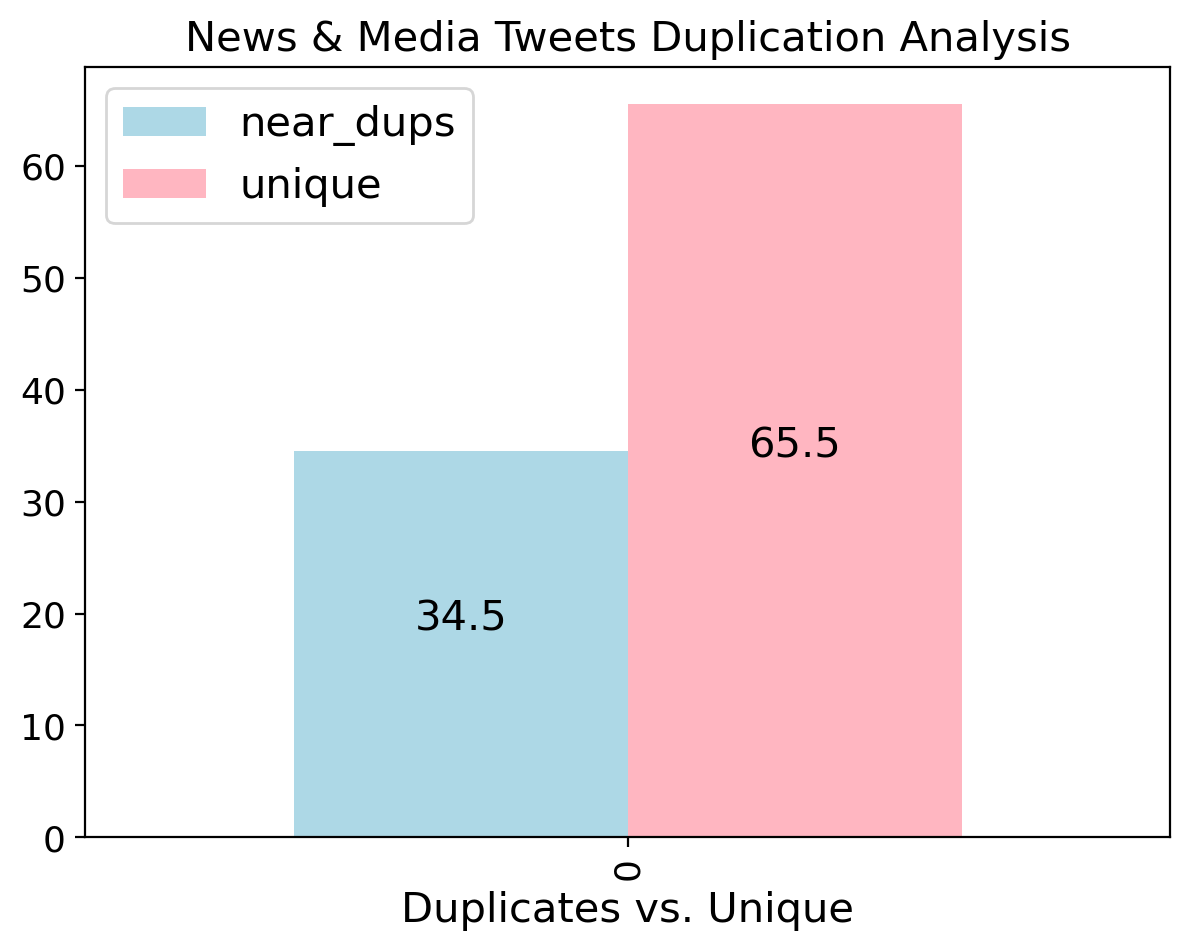

In [167]:
# text
# ngo_dups_ratio = ngo_dups/ngo_records*100
# ngo_uniques_ratio = ngo_uniques/ngo_records*100
ngo_dups_df = pd.DataFrame.from_dict({'near_dups': [34.5], 'unique': [100-34.5]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=ngo_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News & Media Tweets Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### **Similarity Test with MinHashLSH - Influencer**

#### Select Influencer relevant data

In [123]:
influ = df.filter((df.twitterer_catogory == 'Influencer') & (df.original_tweet==True) & (df.tweet_text.isNotNull()))

In [124]:
influ.count()

13915

In [125]:
# influ = influ.sample(withReplacement=False, fraction=0.5, seed=8)

In [126]:
influ_text = ngo.select(['tweet_text'])

#### 1. Prep and Clean-up, remove stopwords and create index

In [127]:
StopWords = stopwords.words("english")

influ_text = influ_text.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)

influ_tokens = influ_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.sub("@[A-Za-z0-9_]+","", document))\
    .map( lambda document: re.sub(r'http\S+',"", document))\
    .map( lambda document: re.sub(r'#\w+',"", document))\
    .map( lambda document: re.sub(r'[^\w\s]', '', document))\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 2] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [128]:
row = Row('influ_text')
influ_text_df = influ_text.map(row).zipWithIndex().toDF(['influ_text','id'])
influ_text_df.limit(5)

influ_text,id
{crazy nfl refs t...,660
{us supreme court...,661
{colleges and uni...,662
"{tracy smith, spe...",663
{@foreverkerns @l...,664


In [129]:
influ_text_token = spark.createDataFrame(influ_tokens, ['list_of_words',"id"])
influ_text_token  = influ_text_token.where(col('list_of_words').getItem(0).isNotNull())
influ_text_token.limit(5).toPandas()

,list_of_words,id
0,"[tories, ashamed, people, woefully, lowcalibre, representing, mean, embarrassingly, cringeinducingly, school, really, isnt, earning, astronomical, fees, days]",0
1,"[dont, recall, many, airplane, tantrum, videos, southwest, tbh, ive, always, great, experiences, flying, flew, lot, college, might, first, class, passenger, thing, lowkey]",1
2,"[tpsc, recruitment, 2022, apply, assistant, professor, kokborok, posts, salary, rs57700, 182400, last, date, 08062022, know, amp, apply, click]",2
3,"[coincidence, college, back, session, penguins, pumping]",3
4,"[youll, probably, find, thing, every, college, well, maybe, kabul, poly, tech]",4


In [130]:
influ_text_token.count()

7389

#### 2. Fit countvectorizer to create word features

In [131]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
influ_vectorize_text = vectorize.fit(influ_text_token).transform(influ_text_token)

In [132]:
influ_vectorize_text.limit(5).toPandas()

,list_of_words,id,features
0,"[tories, ashamed, people, woefully, lowcalibre, representing, mean, embarrassingly, cringeinducingly, school, really, isnt, earning, astronomical, fees, days]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[dont, recall, many, airplane, tantrum, videos, southwest, tbh, ive, always, great, experiences, flying, flew, lot, college, might, first, class, passenger, thing, lowkey]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...)"
2,"[tpsc, recruitment, 2022, apply, assistant, professor, kokborok, posts, salary, rs57700, 182400, last, date, 08062022, know, amp, apply, click]",2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[coincidence, college, back, session, penguins, pumping]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[youll, probably, find, thing, every, college, well, maybe, kabul, poly, tech]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


#### 3. Fit MinHashLSH to create hash table

In [133]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(influ_vectorize_text)
influ_hashed = mh.fit(influ_vectorize_text).transform(influ_vectorize_text)

In [134]:
influ_hashed.limit(5).toPandas()

,list_of_words,id,features,hashes
0,"[tories, ashamed, people, woefully, lowcalibre, representing, mean, embarrassingly, cringeinducingly, school, really, isnt, earning, astronomical, fees, days]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[98406372.0], [445988.0], [65443528.0], [151348924.0], [109284690.0]]"
1,"[dont, recall, many, airplane, tantrum, videos, southwest, tbh, ive, always, great, experiences, flying, flew, lot, college, might, first, class, passenger, thing, lowkey]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...)","[[32821501.0], [118495847.0], [140540522.0], [76317376.0], [20684347.0]]"
2,"[tpsc, recruitment, 2022, apply, assistant, professor, kokborok, posts, salary, rs57700, 182400, last, date, 08062022, know, amp, apply, click]",2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[96403981.0], [20340849.0], [30854182.0], [287068175.0], [290933413.0]]"
3,"[coincidence, college, back, session, penguins, pumping]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[47945584.0], [214924158.0], [267061302.0], [236547207.0], [212954437.0]]"
4,"[youll, probably, find, thing, every, college, well, maybe, kabul, poly, tech]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[4045642.0], [238327555.0], [134161987.0], [174731806.0], [212526061.0]]"


In [135]:
influ_hashed_text = influ_text_df.join(influ_hashed, "id", how = 'left')

In [136]:
influ_hashed_text.count()

7391

#### 4. Establish similarity threshold and return near-duplicate records

In [137]:
jaccard_distance = 0.3
influ_dups_text = model.approxSimilarityJoin(influ_hashed_text, influ_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.Influ_text').alias('influencer_text_A'),
            col('datasetB.Influ_text').alias('influencer_text_B'),
            )

In [139]:
influ_dups_30 = influ_dups_text
influ_dups_text.cache()
influ_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,influencer_text_A,influencer_text_B
0,0.000000,4544,5735,"(@directdonnyp hi there! i have a sweet new college romance with lots of fluffy moments you might enjoy:\nhttps://t.co/pmsnlsidzs,)","(@tinyjaywonie02 hi there! i have a sweet new college romance with lots of fluffy moments you might enjoy:\nhttps://t.co/pmsnlsidzs,)"
1,0.285714,3182,6594,"(about 1 in 5 college-aged female survivors received assistance from a victim services agency. imagine this is your roommate. explore https://t.co/6qrjsxttd3 for more information.,)","(about 1 in 5 college-aged female survivors received assistance from a victim services agency. imagine this is your nephew. follow https://t.co/dtdrcmws3m for more information.,)"
2,0.285714,797,1741,"(about 1 in 5 college-aged female survivors received assistance from a victim services agency. imagine this is your niece. visit https://t.co/6qrjsxttd3 for more information.,)","(about 1 in 5 college-aged female survivors received assistance from a victim services agency. imagine this is your co-worker. explore https://t.co/ycrv2qc1q8 for more information.,)"
3,0.235294,76,5315,"(one study found that 15% of young women experienced incapacitated rape during their first year of college . imagine this is your son. read this https://t.co/6qrjsxm2rb for more information.,)","(one study found that 15% of young women experienced incapacitated rape during their first year of college . imagine this is your sister. explore https://t.co/xfzmb8yrl1 for more information.,)"
4,0.214286,3182,7329,"(about 1 in 5 college-aged female survivors received assistance from a victim services agency. imagine this is your roommate. explore https://t.co/6qrjsxttd3 for more information.,)","(about 1 in 5 college-aged female survivors received assistance from a victim services agency. imagine this is your roommate. click the link https://t.co/6qrjsxttd3 for more information.,)"


In [140]:
influ_records = influ_hashed_text.count()
influ_dups = influ_dups_text.select('id_A').distinct().count()
influ_uniques = influ_records - influ_dups

#### 5. Near-duplicates V.S. Unique Visualization

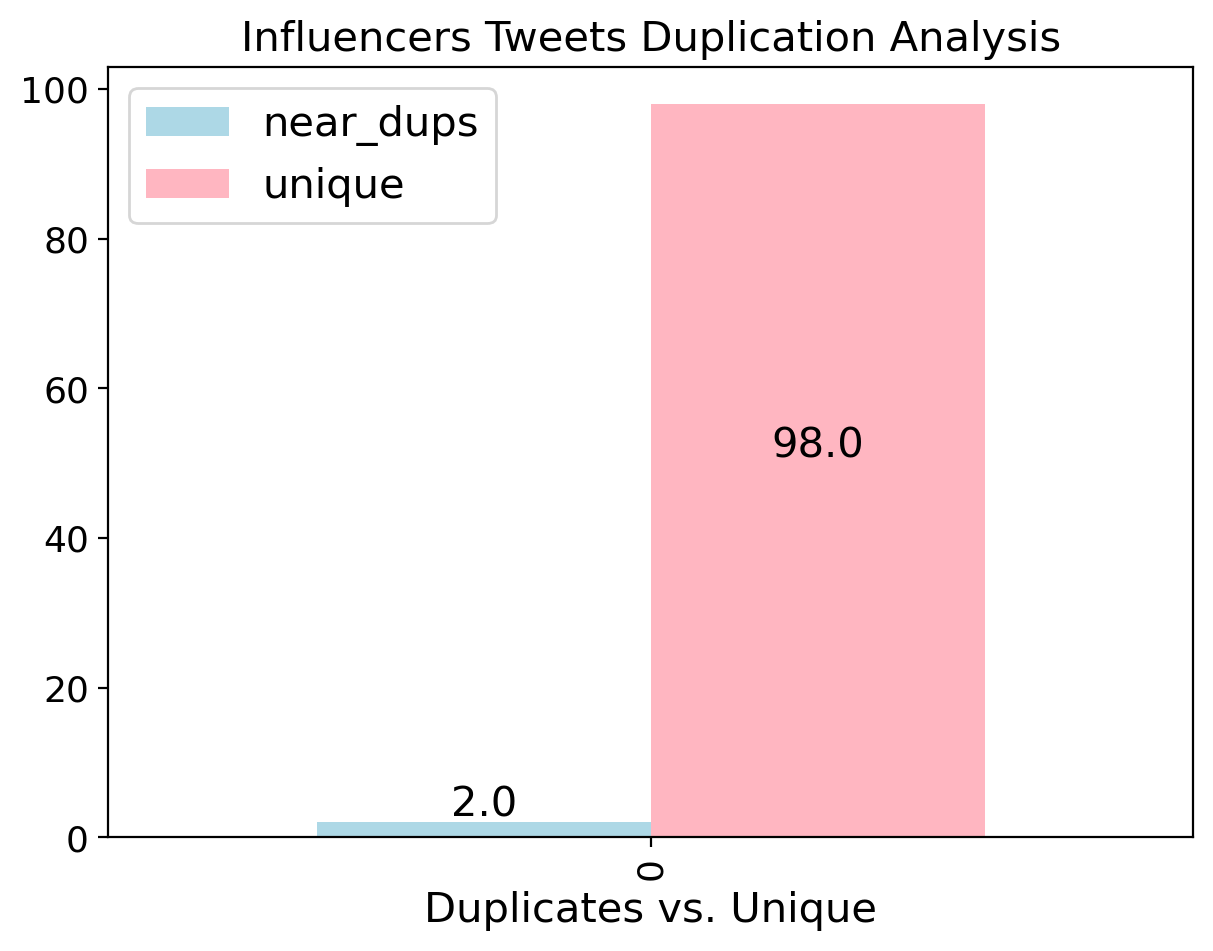

In [141]:
# text
influ_dups_ratio = influ_dups/influ_records*100
influ_uniques_ratio = influ_uniques/influ_records*100
influ_dups_df = pd.DataFrame.from_dict({'near_dups': [influ_dups_ratio], 'unique': [influ_uniques_ratio]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=influ_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Influencers Tweets Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

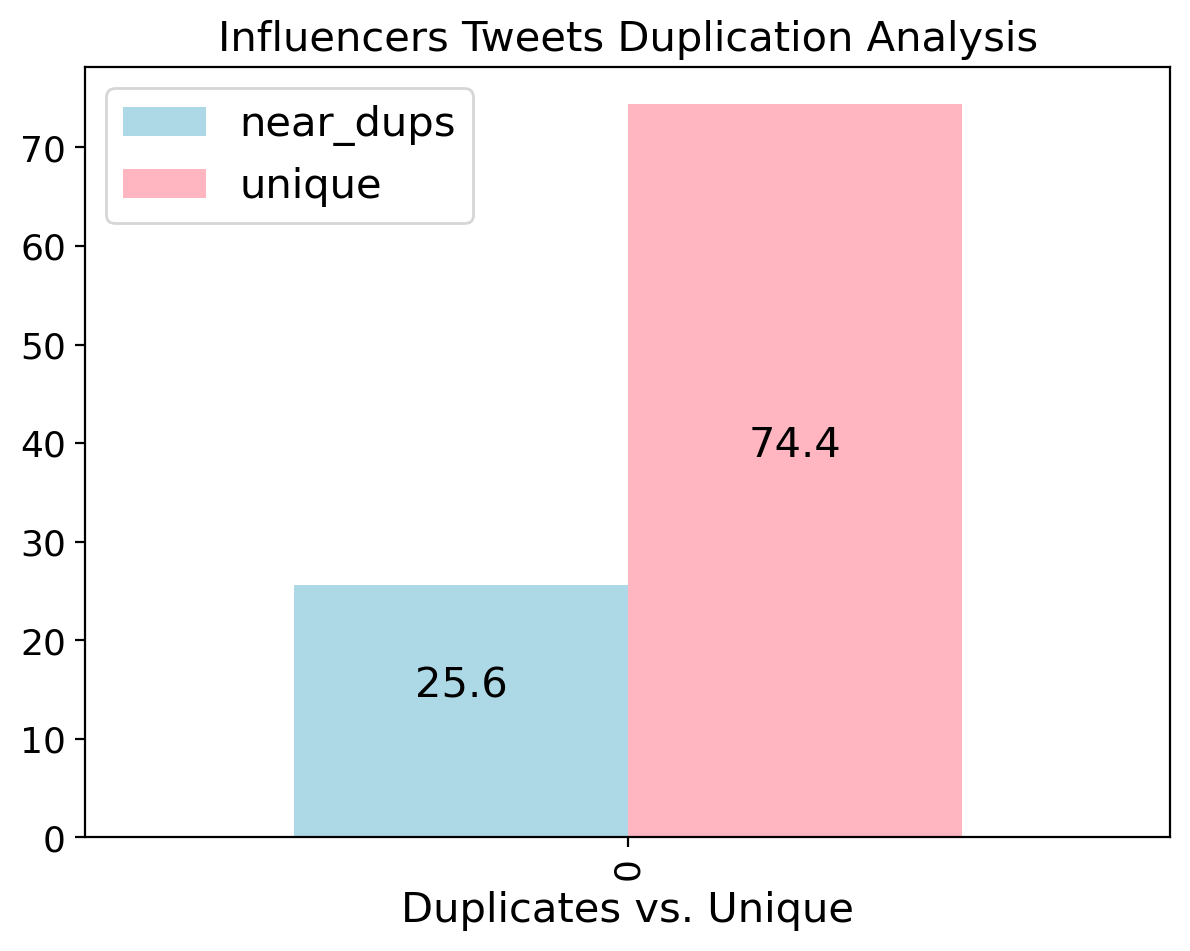

In [168]:
# # text
# influ_dups_ratio = influ_dups/influ_records*100
# influ_uniques_ratio = influ_uniques/influ_records*100
influ_dups_df = pd.DataFrame.from_dict({'near_dups': [25.6], 'unique': [100-25.6]}).round(2)

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

ax=influ_dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=13, color=['lightblue', 'lightpink'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Influencers Tweets Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 